In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


## Functions

In [2]:
results_dict = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'CV_test', 'CV_results.pkl'))
results_dict.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [3]:
iso_stats_list = results_dict['iso_stats']
ab_stats_list = results_dict['ab_stats']

In [4]:
def get_average_and_std_df(results_dict):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    return df_CV


def get_ab_stats_df(results_dict):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        if np.isnan(arr).any():
            print("metric:", metric)
            print(arr)
            print("avg:", avg)
            print("std:", std)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    return df_ab_CV

Calculate averages and std. devs.

In [5]:
df_CV = get_average_and_std_df(results_dict)
df_CV['pre-training'] = "none"
df_CV

,metric,avg,std,pre-training
0,Loss,0.191413,0.005797,none
1,Accuracy,0.927001,0.002470,none
2,Isolate accuracy,0.927001,0.002470,none
3,Sensitivity,0.762480,0.018255,none
4,Specificity,0.972475,0.002763,none
5,F1,0.818718,0.006651,none


## Analysis

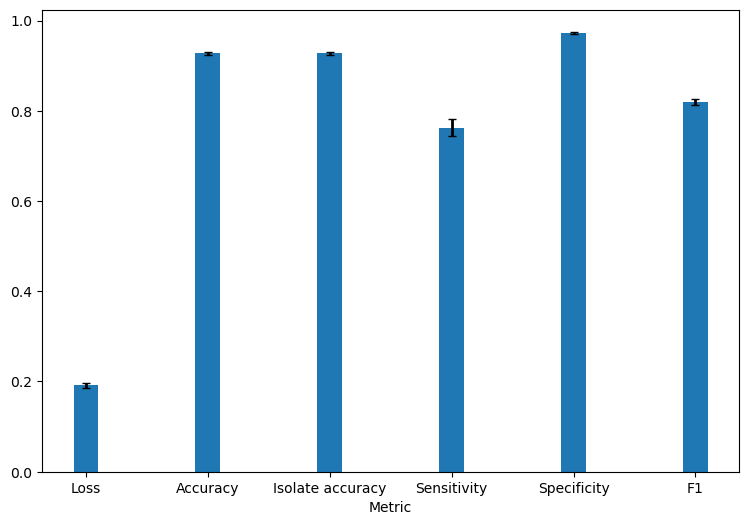

In [6]:
metric_names = ['F1', 'Sensitivity', 'Specificity', 'Accuracy', 'Isolate Accuracy']
fig, ax = plt.subplots(figsize=(9, 6))
ax.bar(df_CV['metric'], df_CV['avg'], width=0.2)
ax.errorbar(df_CV['metric'], df_CV['avg'], df_CV['std'], ecolor="k", fmt="none", elinewidth=2, capsize=3)
ax.set_xlabel("Metric")
plt.show()

In [7]:
df_ab_CV = get_ab_stats_df(results_dict)
df_ab_CV

metric: precision
[[0.91687657 0.87700535 0.91363636 0.90163934 0.93589744 0.78947368
  0.82666667        nan 0.93491124 0.6        0.96153846 0.88      ]
 [0.9017199  0.85465116 0.92417062 0.92820513 0.94776119 0.72519084
  0.78823529 1.         0.96273292 0.625      1.         0.88235294]
 [0.88288288 0.87830688 0.90954774 0.89952153 0.94366197 0.79710145
  0.83529412 0.33333333 0.92638037 0.75       1.         0.76923077]
 [0.92875318 0.8852459  0.84810127 0.9178744  0.92666667 0.73484848
  0.78313253 1.         0.85561497 0.7        0.96       0.68085106]
 [0.85797665 0.86842105 0.9047619  0.88669951 0.91724138 0.8
  0.87341772        nan 0.90797546 0.85714286 1.         0.90625   ]]
avg: [0.89764184 0.87272607 0.90004358 0.90678798 0.93424573 0.76932289
 0.82134927 0.77777778 0.91752299 0.70642857 0.98430769 0.82373695]
std: [0.02508256 0.0105018  0.02674873 0.01459081 0.01114138 0.03241885
 0.03313883 0.31426968 0.03563285 0.09231711 0.01922523 0.08578703]
metric: F1
[[0.81340782

,antibiotic,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,1061,29.346209,0.528855,0.471145,0.005463,0.005463,0.851608,0.006598,0.773824,0.038868,0.920392,0.026237,0.897642,0.025083,0.829948,0.012763
1,CAZ,730,14.998667,0.731544,0.268456,0.012136,0.012136,0.913430,0.007414,0.801977,0.020634,0.955826,0.003124,0.872726,0.010502,0.835679,0.011746
2,CIP,1283,16.475436,0.808251,0.191749,0.005569,0.005569,0.940657,0.006394,0.775623,0.030840,0.979459,0.006814,0.900044,0.026749,0.832563,0.018941
3,CRO,1155,6.693280,0.809896,0.190104,0.009187,0.009187,0.947856,0.008725,0.814016,0.046073,0.980087,0.003154,0.906788,0.014591,0.857060,0.024710
4,CTX,160,8.867920,0.125000,0.875000,0.017282,0.017282,0.915680,0.020444,0.971690,0.024852,0.537722,0.050093,0.934246,0.011141,0.952373,0.012204
5,FEP,741,12.846789,0.815321,0.184679,0.010157,0.010157,0.908479,0.008545,0.717469,0.034383,0.951430,0.008469,0.769323,0.032419,0.741730,0.024484
6,GEN,1167,22.249494,0.874891,0.125109,0.007369,0.007369,0.919819,0.005555,0.458811,0.024695,0.985754,0.002792,0.821349,0.033139,0.588144,0.021931
7,IPM,511,10.770330,0.982353,0.017647,0.005036,0.005036,0.983485,0.004855,0.103030,0.084306,0.999200,0.001600,0.777778,0.314270,0.271876,0.036239
8,LVX,585,13.496666,0.695876,0.304124,0.005393,0.005393,0.935257,0.010443,0.866336,0.014684,0.965538,0.015870,0.917523,0.035633,0.890715,0.017019
9,MFX,11,1.496663,0.307692,0.692308,0.122032,0.122032,0.691803,0.075135,0.893651,0.090574,0.315714,0.177649,0.706429,0.092317,0.783083,0.061539
